# Recommendation Engine

This is a recommendation engine built on company electronics company X's sales dataset. 

The dataset contains information of each sale that was made; the columns are lists of the **Billing Date, item purchased(MaterialDesc), item code(MaterialNumber), division of items(fan, wires, etc.), Customer Name,** and other features. It has **91046** entries and **15** features for each entry, and data has been already pre-processed to remove any missing values.

Our main goal is to recommend similar items to a customer who has already purchased one or more items. In order to use the algorithm one more column was added named **"rating"** which binarily signifies each user-item interaction. Rating **1** is given for each user who had puchased a product. Users are small shops and firms who places orders for electronics products.

In [1]:
# libraries required to work with arrays and dataframes.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
# having a peek at the dataset
location = './RI/data/Recommendation_data.csv'
data = pd.read_csv(location, encoding = 'latin1')
# removing column for non-disclosure of company name
data.drop("DivisionDesc", axis = 1, inplace = True)
data.head()

C:\Users\hp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,BillingDocument,BillingItem,Billingdate,MaterialNumber,MaterialDesc,Division,CustomerNumber,CustomerName,NetValue,ActualInvoicedQuantity,DistributionChannel,ChannelDesc,BillingType,rating
0,5253048973,900,1/1/2016,WHFFDNKL11X5,SC 1.5 SQMM FX BK 180 M,75,CKR0001,K Raj and Co,6517.52,4.0,10,DEALER,ZNE1,1
1,5253048988,400,1/1/2016,FHCPASTBRN36,900 mm FAN PACER BROWN,45,CTA0172,Tarzan Enterprises,8165.56,6.0,15,DISTRIBUTOR,ZNE1,1
2,5253048987,2400,1/1/2016,FHCNISTPWS24,600 mm FAN NICOLA PEARL WHITE SILVER,45,CTA0172,Tarzan Enterprises,7497.03,4.0,15,DISTRIBUTOR,ZNE1,1
3,5253048989,240,1/1/2016,FHCNISTSCH48,1200 mm FAN NICOLA SILVER CHROME,45,CTA0172,Tarzan Enterprises,18742.18,10.0,15,DISTRIBUTOR,ZNE1,1
4,5253048992,40,1/1/2016,FHCSSSTWHT36,900 mm FAN SS390 WHITE,45,CTA0172,Tarzan Enterprises,5650.62,4.0,15,DISTRIBUTOR,ZNE1,1


In [3]:
data.shape

(91046, 14)

For our recommendation engine we will only require three columns. The **user name, the material and the rating** of their interaction. We also need to find out the number of unique users and items in the dataset. From now on we will be continuing in terms of **users** and **items**.

In [4]:
def create_data(dataframe, user_id = 'MaterialDesc', item_id = 'CustomerName', rating = 'rating'):
    # creating a new dataframe having the required columns
    features = [item_id, user_id, rating]
    df = data[features]
    df.to_json("./RI/data/Recommendation_data.json", orient = "index")
    return df

df = create_data(data)
df.head()

,CustomerName,MaterialDesc,rating
0,K Raj and Co,SC 1.5 SQMM FX BK 180 M,1
1,Tarzan Enterprises,900 mm FAN PACER BROWN,1
2,Tarzan Enterprises,600 mm FAN NICOLA PEARL WHITE SILVER,1
3,Tarzan Enterprises,1200 mm FAN NICOLA SILVER CHROME,1
4,Tarzan Enterprises,900 mm FAN SS390 WHITE,1


In [5]:
# finding the distinct number of users and items
n_users = len(df.CustomerName.unique())
n_items = len(df.MaterialDesc.unique())
print("Users: ", n_users, "Items: ", n_items)

Users:  10 Items:  4783


## Recommender Systems

There are multiple recommendation system algorithms, but for this type of problem **Item-Item Collaborative Filtering** is used.Two most ubiquitous types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 

Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. 

In contrast, content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them. Let us know more about this Collaborative Filtering algorithm.

## Collaborative Filtering Algorithm

Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

### User-Item filtering
A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

This algorithm is very effective but takes a lot of time and resources. It requires to compute every customer pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system. 

### Item-Item filtering
Item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new customer the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between customers. And with fixed number of products, product-product look alike matrix is fixed over time. 
* *Item-Item Collaborative Filtering: “Users who liked this item also liked …”*
* *User-Item Collaborative Filtering: “Users who are similar to you also liked …”*  

In both cases, you create a user-item matrix which you build from the entire dataset. Since you have split the data into **testing** and **training** you will need to create two **10 × 4783** matrices. The training matrix contains 75% of the ratings and the testing matrix contains 25% of the ratings.

In [6]:
# diving our dataset into training and test dataset
train_data, test_data = train_test_split(df, test_size = 0.25)

# creating an empty dataset having row names as users and column names as itmes
customers = df['CustomerName'].drop_duplicates()
materials = df['MaterialDesc'].drop_duplicates()
train_data_items = pd.DataFrame(0, index= customers, columns= materials)
test_data_items = pd.DataFrame(0, index= customers, columns= materials)

# filling the dataset with the rating to generate a sparse dataset
for row in train_data.itertuples():
    train_data_items[row[2]][row[1]] = row[3]
    
for row in test_data.itertuples():
    test_data_items[row[2]][row[1]] = row[3]

In [7]:
train_data_items.head(10)

MaterialDesc,SC 1.5 SQMM FX BK 180 M,900 mm FAN PACER BROWN,600 mm FAN NICOLA PEARL WHITE SILVER,1200 mm FAN NICOLA SILVER CHROME,900 mm FAN SS390 WHITE,1200 mm FAN NICOLA PEARL WHITE SILVER,UTP CAT 5E COMPUTER LAN CABLE 305M,SC 6.0 SQMM FX BL 180 M,1200 mm FAN FUSION PEARL IVORY,SC 1.5 SQMM FX RD 180 M,...,16 A SP C MINI MCB Fabio,20 A SP C MINI MCB Fabio,ENDURAHIBRITEPLUSHBP90WLED76590DTOLENS,H.Decor BRITO Upto 20W Led Ball E27 GR,LED DRIVER 36W 36V/900mA,SENZO 5S 10LTR SM FP WHITE-SWH,8 MODULE HORZ.METAL BOX (G I) New,10 A SP C MINI MCB Coral,400A 3P 36/36kA TAMA L Fr.MCCB,INTEGRANEODLR15WLED857S
CustomerName,,,,,,,,,,,,,,,,,,,,,
K Raj and Co,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Tarzan Enterprises,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Sai Marketing,1,1,0,0,1,1,1,1,1,1,...,0,1,0,0,0,0,0,1,0,0
Spectrum Light and Electricals,1,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
Relax Agencies,0,1,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Mary Electricals,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
Laxmi Lamp House,1,0,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
A A Electricals,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
A B P Enterprises Pvt.Ltd.,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Item-Item Based Collaborative filtering for the dataset

In our dataset we have set the ratings as **1** if a user has purchased that item and **0** if he has not. Now our next step is to:
* Find similar items by using a similarity metric
* For a user, recommend the items most similar to the items (s)he already likes

### Similarity Matrix

A similarity matrix is a user-user or item-item marix cosisting of the similarities metric of each user or item pair. A **similarity metric** is a metric used to determine the measure of similarity between two item or user vectors. The most commonly used similarity metrics are:

**Jaccard Similarity**:  
* Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B    
* It is typically used where we don’t have a numeric rating but just a **boolean value** like a product being bought or an add being clicked  

Jaccard Similarity is given by Sij= p/(p+q+r)
where,  

p = number of attributes positive for both objects   
q = number of attributes 1 for i and 0 for j    
r = number of attributes 0 for i and 1 for j   

**Cosine Similarity:**
* Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
* Closer the vectors, smaller will be the angle and larger the cosine

cosine similarity = A⋅B/∥A∥∥B∥ where A and B are object vectors.

**Pearson Similarity**
* Similarity is the pearson coefficient between the two vectors.
* pearson coefficient is the cosine similarity of normalized user or item vectors


### Jaccard Similarity

The metric used for similarity was Jaccard Similarity as we have boolean ratings.

In [8]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = 1 - pairwise_distances(train_data_items.transpose(), metric='jaccard')
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
sim_matrix = calculate_similarity(train_data_items)
print(sim_matrix.shape)
# Lets get the top 11 similar items for 1200 mm FAN FUSION PEARL IVORY
print(sim_matrix.loc['1200 mm FAN FUSION PEARL IVORY'].nlargest(10))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


(4783, 4783)
MaterialDesc
1200 mm FAN FUSION PEARL IVORY           1.000000
1200 mm FAN XP390 PLUS BROWN             1.000000
1200 mm FAN XP390 PLUS ELEGANT WHITE     1.000000
1200 mm FAN FUSION BEIGE BROWN           0.857143
1200 mm FAN FUSION SILVER BLUE           0.857143
1200 mm FAN NICOLA PEARL WHITE SILVER    0.833333
1200 mm FAN AREOLE PEARL BROWN           0.833333
900 mm FAN FUSION PEARL IVORY            0.833333
175 mm I-COOL PERSONAL FAN BLACK GREY    0.833333
230 mm FAN VENTIL AIR DB                 0.833333
Name: 1200 mm FAN FUSION PEARL IVORY, dtype: float64


### Predicting user-item ratings for similar items

If **Rx** be the vector of user **x's** rating and **N** be the set of **k** most similar items to the items purchased by **x**. Prediction of user **x** and item **i** can be simply given as the weighted average given as:

<img src="./r7.png",width=500>

The neighnourhood of 10 items for each item purchased by a user is specified. We can tweak with this value according to the number of similar items we want to include. For more similar items we can increase this number and vice versa.

In [9]:
# func determines top 10 recommendations for each user
def recommendations(user, data_matrix, similarity_matrix):
    #------------------------
    # USER-ITEM CALCULATIONS
    #------------------------

    # Construct a new dataframe with the 10 closest neighbours (most similar)
    # for each artist.
    data_neighbours = pd.DataFrame(index=similarity_matrix.columns, columns=range(1,11))
    for i in range(0, len(similarity_matrix.columns)):
        data_neighbours.iloc[i,:10] = similarity_matrix.iloc[0:,i].sort_values(ascending=False)[:10].index

    # Get the items the user has purchased.
    known_user_likes = data_matrix.loc[user]
    known_user_likes = known_user_likes[known_user_likes >0].index.values

    # Construct the neighbourhood from the most similar items to the
    # ones our user has already purchased.
    most_similar_to_likes = data_neighbours.loc[known_user_likes]
    similar_list = most_similar_to_likes.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = similarity_matrix[similar_list].loc[similar_list]

    # A user vector containing only the neighbourhood items and
    # the known user purchases.
    user_vector = data_matrix.loc[user].loc[similar_list]

    # Calculate the score.
    score = neighbourhood.dot(user_vector).div(neighbourhood.sum(axis=1))

    # Drop the known purchases.
    for i in known_user_likes:
        if i in score.index:
            score = score.drop(i)
            
    return score.nlargest(5)

print(recommendations("K Raj and Co", train_data_items, sim_matrix))

MaterialDesc
6A 2 pin Socket Oro                         0.830882
SENZO 5S 15LTR SM FP WHITE-SWH              0.826334
1200 mm FABIO PLATINUM BRUSHED NICKEL       0.822806
1320 mm FAN DEW VIKING TEAK BRUSH NICKEL    0.822806
230 mm BIRDIE PERSONAL YELLOW MR FAN        0.822806
dtype: float64


### Bonus: Cosine Similarity

Before using cosine similarity we need to normalize our ratings so that each user vector is a unit vector.

This is the idea of normalizing the user vectors was implemented so that a user with many ratings contributes less to any individual rating. This is to say that a like from a user who has only liked 10 items is more valuable to us than a like from someone who likes everything she comes across.

In [10]:
def normalize(matrix):
    # We might need to normalize the user vectors to unit vectors for some algoritms to work effectively.
    # magnitude = sqrt(x2 + y2 + z2 + ...) ; here x,y,z.. are item vectors
    magnitude = np.sqrt(np.square(matrix).sum(axis=1))

    # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
    matrix = matrix.divide(magnitude, axis='index')
    return matrix

#normalized training data
norm_data_items = normalize(train_data_items)
norm_data_items.head()

MaterialDesc,SC 1.5 SQMM FX BK 180 M,900 mm FAN PACER BROWN,600 mm FAN NICOLA PEARL WHITE SILVER,1200 mm FAN NICOLA SILVER CHROME,900 mm FAN SS390 WHITE,1200 mm FAN NICOLA PEARL WHITE SILVER,UTP CAT 5E COMPUTER LAN CABLE 305M,SC 6.0 SQMM FX BL 180 M,1200 mm FAN FUSION PEARL IVORY,SC 1.5 SQMM FX RD 180 M,...,16 A SP C MINI MCB Fabio,20 A SP C MINI MCB Fabio,ENDURAHIBRITEPLUSHBP90WLED76590DTOLENS,H.Decor BRITO Upto 20W Led Ball E27 GR,LED DRIVER 36W 36V/900mA,SENZO 5S 10LTR SM FP WHITE-SWH,8 MODULE HORZ.METAL BOX (G I) New,10 A SP C MINI MCB Coral,400A 3P 36/36kA TAMA L Fr.MCCB,INTEGRANEODLR15WLED857S
CustomerName,,,,,,,,,,,,,,,,,,,,,
K Raj and Co,0.059549,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059549,0.059549,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Tarzan Enterprises,0.018194,0.018194,0.018194,0.018194,0.018194,0.018194,0.018194,0.018194,0.018194,0.018194,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Sai Marketing,0.028194,0.028194,0.000000,0.000000,0.028194,0.028194,0.028194,0.028194,0.028194,0.028194,...,0.0,0.028194,0.0,0.0,0.0,0.0,0.0,0.028194,0.0,0.0
Spectrum Light and Electricals,0.027462,0.027462,0.027462,0.000000,0.027462,0.027462,0.000000,0.000000,0.027462,0.027462,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Relax Agencies,0.000000,0.055728,0.055728,0.055728,0.000000,0.055728,0.000000,0.000000,0.055728,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [11]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = 1 - pairwise_distances(train_data_items.transpose(), metric='cosine')
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
cos_sim_matrix = calculate_similarity(norm_data_items)

# Lets get the top 11 similar items for 1200 mm FAN FUSION PEARL IVORY
print(cos_sim_matrix.loc['1200 mm FAN FUSION PEARL IVORY'].nlargest(10))

MaterialDesc
1200 mm FAN FUSION PEARL IVORY           1.000000
1200 mm FAN XP390 PLUS BROWN             1.000000
1200 mm FAN XP390 PLUS ELEGANT WHITE     1.000000
1200 mm FAN FUSION BEIGE BROWN           0.925820
1200 mm FAN FUSION SILVER BLUE           0.925820
1200 mm FAN NICOLA PEARL WHITE SILVER    0.912871
1200 mm FAN AREOLE PEARL BROWN           0.912871
900 mm FAN FUSION PEARL IVORY            0.912871
175 mm I-COOL PERSONAL FAN BLACK GREY    0.912871
230 mm FAN VENTIL AIR DB                 0.912871
Name: 1200 mm FAN FUSION PEARL IVORY, dtype: float64


## Evaluation

There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE).
<img src="./r8.png",width=300>
You can use the mean_square_error (MSE) function from sklearn, where the RMSE is just the square root of MSE.

Since you only want to consider predicted ratings that are in the test dataset, you filter out all other elements in the prediction matrix with prediction[ground_truth.nonzero()].

In [12]:
### predicting the score for each use-item interaction ###

# training data matrix
train_data_matrix = np.array(train_data_items.values)
# jaccard similarity matrix
similarity_matrix = np.array(sim_matrix.values)
# cosine similarity matrix
cos_similarity_matrix = np.array(cos_sim_matrix.values)
def predict(ratings, similarity, type='item'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [13]:
# predicted rating matrix
item_prediction = predict(train_data_matrix, similarity_matrix, type='item')
# replacing NA value swith zeroes for jaccard similarity
np.nan_to_num(item_prediction, copy = False)
# predicted rating matrix using cosine similarity
item_prediction_cos = predict(train_data_matrix, cos_similarity_matrix, type='item')

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [15]:
# eavaluating the score on the test data mtrix
jaccard_error = rmse(item_prediction, np.array(test_data_items))
cosine_error = rmse(item_prediction_cos, np.array(test_data_items))
print('Item-based CF RMSE: ', str(jaccard_error))
print('Item-based CF RMSE(cos): ', str(cosine_error))

Item-based CF RMSE:  0.5496830180248151
Item-based CF RMSE(cos):  0.5743952427044021


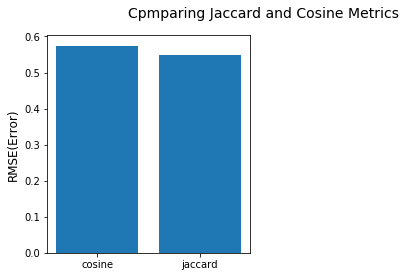

In [16]:
# plotting the rmse values for jaccard and cosine similarities
# for pickle and joblib model
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 4))

ax1 = fig.add_subplot(121)
ax1.bar(['jaccard', 'cosine'], [jaccard_error, cosine_error])

ax1.set_ylabel('RMSE(Error)', size = 12)

plt.suptitle('Cpmparing Jaccard and Cosine Metrics', size = 14)

plt.show()

As a result we can conclude that using **jaccard similarity** in case of **binary ratings**; where information, if a user has rated a item or not is given, is a better option

In [17]:
# Saving the recommendations in json format
l = []
for customer in customers:
    rec = recommendations(customer, train_data_items, sim_matrix)
    for i,j in zip(rec, rec.index):
        d = {'customer': customer, 'item': j, 'score': i}
        l.append(d)

### Persisting our recommendations

The final recommendations for each user along with their score is shown below.

In [18]:
import json
with open("./RI/data/Recommendations.json", "w") as json_data:
    json.dump(l, json_data)

In [19]:
jd = pd.read_json('./RI/data/Recommendations.json', orient = 'records')
jd.head(10)

,customer,item,score
0,K Raj and Co,6A 2 pin Socket Oro,0.830882
1,K Raj and Co,SENZO 5S 15LTR SM FP WHITE-SWH,0.826334
2,K Raj and Co,1200 mm FABIO PLATINUM BRUSHED NICKEL,0.822806
3,K Raj and Co,1320 mm FAN DEW VIKING TEAK BRUSH NICKEL,0.822806
4,K Raj and Co,230 mm BIRDIE PERSONAL YELLOW MR FAN,0.822806
5,Tarzan Enterprises,1200 mm FAN FUSION WINE RED,0.992171
6,Sai Marketing,2C 1.0 SQMM EXTRA FLEX BK 100M,0.986866
7,Sai Marketing,3C 4.0 SQMM EXTRA FLEX BK 100M,0.986714
8,Sai Marketing,FRLSH SC 2.5 SQMM FX GN 90M,0.982199
9,Sai Marketing,1M cover Plate Verona PROJ,0.982065
